This notebook is based on coursera's Practical RL course by National Research University Higher School of Economics, https://www.coursera.org/learn/practical-rl/home/welcome

We will make a DQN-Learning agent to solve OpenAI Gym's CartPole problem.

Q-Learning update equations:


*   tabular: $$ Q(s,a) := (1 - \alpha) \cdot Q(s,a) + \alpha \cdot (r(s,a) + \gamma \cdot V(s')) \\ = Q(s,a) + \alpha \cdot (r(s,a) + \gamma \cdot V(s') - Q(s,a))$$
*    DQN: $$ L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2 $$

In [1]:
from collections import defaultdict
import random, math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.optim as optim

manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
#XVFB will be launched if you run on a server
import os
if os.environ.get("DISPLAY") is not str or len(os.environ.get("DISPLAY"))==0:
    #!bash ../xvfb start
    %env DISPLAY=:1

env: DISPLAY=:1


In [3]:
!apt-get -qq -y install xvfb freeglut3-dev cmake swig ffmpeg> /dev/null 2>&1
!pip install pyvirtualdisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()
%matplotlib inline

2
1
Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
state:
[ 0.04161798 -0.04537389 -0.01055042  0.04160573]
4


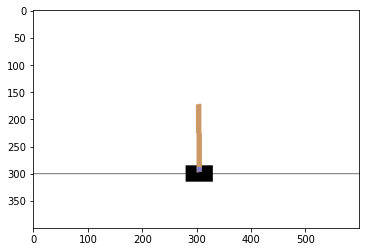

In [4]:
import gym

env = gym.make("CartPole-v0").env
s = env.reset()

n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

print(n_actions)
print(env.action_space.sample())
# continuous (!) valued observations: Cart Position, Cart Velocity, Pole Angle, Pole Velocity at Tip
print(env.observation_space)
print('state:')
print(s)
print(state_dim)
plt.imshow(env.render('rgb_array'))

In [5]:
class DQNAgent:
    def __init__(self, state_dim, n_actions, epsilon=0, device='cuda'):
        """A simple DQN agent"""
        
                         
        # Create a network for approximate q-learning:
        # what is the input dimension?
        # Linear(128), followed by RELU activation
        # Linear(128), followed by RELU activation
        # Last linear output layer: what should be the number of units?
        self.network = nn.Sequential(
            nn.Linear(in_features=state_dim, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=n_actions)
        ).to(device)
            
        self.epsilon = epsilon
        self.device = device
        
    def get_qvalues(self, state_t):
        return self.network(state_t)
    
    def sample_action(self, qvalues):
        """Pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        # choose random actions with np.random.choice
        # there have to be batch_size of them - one for every batch instance
        random_actions = np.random.choice(n_actions, batch_size)
        # for every batch instance calculate the index of the maximum qvalue
        # hint: use the axis
        best_actions = np.argmax(qvalues, axis=-1)
        # with probability epsilon should explore is 1 and else 0 for every batch instance
        # this is a mask we will use in np.where to select
        should_explore = np.random.choice([0.0, 1.0], size=(batch_size), replace=True, p=[1-epsilon, self.epsilon])
        # take random_actions is should_explore is 1 and best_actions else
        return np.where(should_explore, random_actions, best_actions)
    
    def get_action(self, state_t):
        # since in our case we learn on 1 sample only, we put the state into list to make batch_size=1
        state_pt = torch.Tensor([state_t]).float().to(self.device)
        qvalues = self.get_qvalues(state_pt).cpu().detach().numpy()
        
        # sample an action for the qvalues
        # sample_action returns a list, so we take the first element, because our batch_size=1
        return self.sample_action(qvalues)[0]
    
    def update(self, s, a, r, next_s, done):
        self.optimizer.zero_grad()
        
        loss = self.loss_function([s],[a],[r],[next_s],[done])
        
        # backpropagate the loss and make an optimizer step
        loss.backward()
        self.optimizer.step()
        
    def loss_function(self, states, actions, rewards, next_states, is_done):
        states_tmp = torch.Tensor(states).float().to(self.device)
        actions_tmp = np.array(actions) # assure its an array and not a list
        rewards_tmp = torch.Tensor(rewards).float().to(self.device)
        next_states_tmp = torch.Tensor(next_states).float().to(self.device)
        is_done_tmp = torch.Tensor(is_done).float().to(self.device)
        
        is_not_done = 1. - is_done_tmp
        gamma = 0.99

        """Take q-values for actions agent just took"""
        # get agent's qvalues for the states
        current_qvalues = self.get_qvalues(states_tmp)
        
        # Create a one-hot target encoding
        # 1. use numpy tp create an empty one-hot matrix of dimensions (batch_size, n_actions)
        one_hot_actions = np.zeros((actions_tmp.shape[0], n_actions))

        # 2. set target idx to 1
        one_hot_actions[np.arange(actions_tmp.shape[0]), actions_tmp] = 1.0
        # 3. convert to torch.Tensor
        one_hot_actions = torch.Tensor(one_hot_actions).float().to(self.device)
        
        # for every batch instance, get the qvalue for the chosen action
        # hint: use one_hot_actions and current_q_values, do not forget to set keepdim=True
        current_action_qvalues = torch.sum(one_hot_actions*current_qvalues, dim=1, keepdim=True)

        # compute q-values for NEXT states
        # hint: use next_states_ph
        next_qvalues_target = self.get_qvalues(next_states_tmp)

        # compute state values by taking max over next_qvalues_target for all actions
        # hint: use next_qvalues_target and do not forget to set keepdim=True
        next_state_values_target,_ = torch.max(next_qvalues_target, dim=1, keepdim=True)

        # compute Q_reference(s,a) as per r + gamma*v_next*is_not_done
        # ATTENTION: think about what v_next is
        reference_qvalues = rewards_tmp + gamma * next_state_values_target * is_not_done
        # stop gradients of reference_qvalues
        reference_qvalues = reference_qvalues.detach()

        # Define loss function for sgd.
        td_loss = (reference_qvalues - current_action_qvalues) * (reference_qvalues - current_action_qvalues)
        td_loss = torch.mean(td_loss)
        
        return td_loss
        
    def set_optimizer(self):
        
        self.optimizer = optim.Adam(self.network.parameters(), lr=1e-4)

In [6]:
agent = DQNAgent(state_dim, n_actions, epsilon=0.5, device='cuda')
print(agent.network)

Sequential(
  (0): Linear(in_features=4, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=2, bias=True)
)


In [7]:
# since it is an NN agent, we need to set an optimizer
agent.set_optimizer()

In [8]:
# update at each train step
def play_and_train(env,agent,t_max=1000, train=True):
    """
    This function should 
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        # get agent to pick action given state s.
        a = agent.get_action(s)
        
        # get next_state, reward etc.
        ns, r, done, _ = env.step(a)
        
        if train:
            # train (update) agent for state s
            agent.update(s, a, r, ns, done)
        
        s = ns
        total_reward +=r
        if done: break
        
    return total_reward

* __ mean reward__ is the average reward per game. For a correct implementation it may stay low for some 10 epochs, then start growing while oscilating insanely and converges by ~50-100 steps depending on the network architecture. 
* If it never reaches target score by the end of for loop, try increasing the number of hidden neurons or look at the epsilon.
* __ epsilon__ - agent's willingness to explore. If you see that agent's already at < 0.01 epsilon before it's is at least 200, just reset it back to 0.1 - 0.5.
* you may also try to tweak the learning rate of your optimizer

In [9]:
for i in range(100):
    session_rewards = [play_and_train(env, agent, train=True) for _ in range(100)]
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), agent.epsilon))
    
    agent.epsilon *= 0.99
    assert agent.epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"
    
    if np.mean(session_rewards) > 300:
        print ("You Win!")
        break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


epoch #0	mean reward = 13.240	epsilon = 0.500
epoch #1	mean reward = 15.400	epsilon = 0.495
epoch #2	mean reward = 14.750	epsilon = 0.490
epoch #3	mean reward = 17.080	epsilon = 0.485
epoch #4	mean reward = 22.150	epsilon = 0.480
epoch #5	mean reward = 30.400	epsilon = 0.475
epoch #6	mean reward = 38.420	epsilon = 0.471
epoch #7	mean reward = 42.770	epsilon = 0.466
epoch #8	mean reward = 48.010	epsilon = 0.461
epoch #9	mean reward = 60.050	epsilon = 0.457
epoch #10	mean reward = 82.920	epsilon = 0.452
epoch #11	mean reward = 116.310	epsilon = 0.448
epoch #12	mean reward = 136.910	epsilon = 0.443
epoch #13	mean reward = 167.830	epsilon = 0.439
epoch #14	mean reward = 169.410	epsilon = 0.434
epoch #15	mean reward = 183.950	epsilon = 0.430
epoch #16	mean reward = 176.670	epsilon = 0.426
epoch #17	mean reward = 236.580	epsilon = 0.421
epoch #18	mean reward = 237.250	epsilon = 0.417
epoch #19	mean reward = 268.390	epsilon = 0.413
epoch #20	mean reward = 343.990	epsilon = 0.409
You Win!


In [10]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True)
# set epsilon to 0, since for testing no exploration is needed
agent.epsilon = 0
sessions = [play_and_train(env, agent, train=False) for _ in range(1)]
env.close()

In [11]:
# show video
# the visualization function from 
# https://star-ai.github.io/Rendering-OpenAi-Gym-in-Colaboratory/

from IPython.display import HTML
from IPython import display as ipythondisplay
import io
import base64

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

video = io.open("./videos/"+video_names[-1], 'r+b').read()
encoded = base64.b64encode(video)
ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))